In [1]:
import pandas as pd

# df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')

# df_train1 = df_train[df_train['img_dir'].str.contains('aptos')]
# df_val1 = df_val[df_val['img_dir'].str.contains('aptos')]
# df_trainval1 = pd.concat([df_train1, df_val1], ignore_index=True)

# df_train2 = df_train[df_train['img_dir'].str.contains('diabetic-retinopathy-detection')]
df_val2 = df_val[df_val['img_dir'].str.contains('diabetic-retinopathy-detection')]
# df_trainval2 = pd.concat([df_train2, df_val2], ignore_index=True)

In [ ]:
# df_trainval2['group'] = df_trainval2['id'].str.split('_').str[0]
# df_trainval2_half = df_trainval2.groupby('group', group_keys=False).sample(n=1)
# df_trainval2_half_trimmed = df_trainval2_half.sample(n=1831*9, random_state=42)

# del df_trainval2, df_trainval2_half
# del df_train, df_val, df_train2, df_val2

In [2]:
from sklearn.model_selection import GroupShuffleSplit

df_val2['group'] = df_val2['id'].str.split('_').str[0]

splitter = GroupShuffleSplit(n_splits=1, test_size=1200 * 3 // 2, random_state=42)
val_idx, train_idx = next(splitter.split(X=df_val2, y=None, groups=df_val2['group']))

df_train2_mini = df_val2.iloc[train_idx]
df_val2_mini = df_val2.iloc[val_idx]

df_train2_mini.to_csv('df_train2_mini.csv', index=False)
df_val2_mini.to_csv('df_val2_mini.csv', index=False)

del df_val, df_val2

/tmp/ipykernel_1995/4031597625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val2['group'] = df_val2['id'].str.split('_').str[0]


In [1]:
import pandas as pd

df_train2_mini = pd.read_csv('df_train2_mini.csv')
df_messidor = pd.read_csv('df_messidor.csv')

df_val2_mini = pd.read_csv('df_val2_mini.csv')

In [10]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and 'label' is the column to stratify on
df_train1_new, df_val1_new = train_test_split(df_trainval1, test_size=0.5, random_state=42,
                            stratify=df_trainval1['label'])

df_train1_new.to_csv('df_train1_new.csv', index=False)
df_val1_new.to_csv('df_val1_new.csv', index=False)

In [1]:
import pandas as pd

df_train1_new = pd.read_csv('df_train1_new.csv')
# df_messidor = pd.read_csv('df_messidor.csv')

df_val1_new = pd.read_csv('df_val1_new.csv')

In [ ]:
# df_trainval2_half = pd.read_csv('diabetic-retinopathy-detection/trainLabelsHalf.csv')
# df_trainval2_half.rename(columns={'image': 'id', 'level': 'label'}, inplace=True)
# df_trainval2_half['img_dir'] = 'diabetic-retinopathy-detection/train/processed/' \
#                              + df_trainval2_half['id'] + '.jpeg'
# df_trainval2_half_mini = df_trainval2_half.groupby('label', group_keys=False, sort=False)\
#                                           .apply(lambda x: x.sample(n=356, random_state=42))\
#                                           .sort_index()

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # id = row['id']
        label = int(row['label'])
        img_dir = row['img_dir']

        image = Image.open(img_dir).convert('RGB')  # ensure 3 channels

        if self.transform:
            image = np.array(image)
            image = self.transform(image=image)['image']

        return image, label

In [3]:
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import functional as AF
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2

SMALLEST_SIZE = 477
# IMAGE_SIZE_TRAIN = 352
IMAGE_SIZE_TRAIN = 448
# IMAGE_SIZE_TRAIN = 400
# IMAGE_SIZE_VAL = 544
IMAGE_SIZE_VAL = 768
# IMAGE_SIZE_VAL = 744

def random_downscale(img, **kwargs):
    h, w = img.shape[:2]
    # pick a random target between SMALLEST_SIZE and IMAGE_SIZE_VAL
    N = random.randint(SMALLEST_SIZE, IMAGE_SIZE_VAL)
    # only downscale if image is larger than N
    if max(h, w) > N:
        img = A.LongestMaxSize(max_size=N, p=1.0)(image=img)["image"]
    return img

def downscale(img, **kwargs):
    h, w = img.shape[:2]
    if max(h, w) > IMAGE_SIZE_VAL:
        img = A.LongestMaxSize(max_size=IMAGE_SIZE_VAL, p=1.0)(image=img)["image"]
    return img

train_transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.Lambda(name="RandomDownscale", image=random_downscale, p=1.0),
            A.PadIfNeeded(IMAGE_SIZE_VAL, IMAGE_SIZE_VAL, fill=0)
        ], p=0.1),
        A.Lambda(name="Downscale", image=downscale, p=0.9),
    ], p=1.0),
    # A.Resize(IMAGE_SIZE_VAL, IMAGE_SIZE_VAL),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=360, p=1.0),
    A.RandomCrop(IMAGE_SIZE_TRAIN, IMAGE_SIZE_TRAIN),

    A.RandomBrightnessContrast(
        brightness_limit=0.1,  # ±20% brightness
        contrast_limit=0.2,    # ±20% contrast
        p=0.3
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,        # ±10 degrees
        sat_shift_limit=20,        # ±20%
        val_shift_limit=10,        # ±10%
        p=0.3
    ),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),

    A.CLAHE(p=0.3),

    A.Normalize(  # For model pretrained on ImageNet
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Lambda(name="Downscale", image=downscale),
    # A.Resize(IMAGE_SIZE_VAL, IMAGE_SIZE_VAL),
    A.PadIfNeeded(IMAGE_SIZE_VAL, IMAGE_SIZE_VAL, fill=0),

    A.Normalize(  # For model pretrained on ImageNet
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),

    ToTensorV2(),
])

/home/mauribuntu/miniconda3/envs/causal-dl-torch/lib/python3.12/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE_TRAIN = 10
BATCH_SIZE_VAL = 16

# BATCH_SIZE_TRAIN = 6
# BATCH_SIZE_MESSIDOR = 3
# BATCH_SIZE_VAL = 12

# BATCH_SIZE_TRAIN = 6
# BATCH_SIZE_MESSIDOR = 4
# BATCH_SIZE_VAL = 16

train_dataset = TrainDataset(df_train1_new, train_transform)
# messidor_dataset = TrainDataset(df_messidor, train_transform)
val_dataset = TrainDataset(df_val1_new, val_transform)

# train_dataset = TrainDataset(df_train2_mini, train_transform)
# messidor_dataset = TrainDataset(df_messidor, train_transform)
# val_dataset = TrainDataset(df_val2_mini, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=11)
# messidor_dataloader = DataLoader(messidor_dataset, batch_size=BATCH_SIZE_MESSIDOR, shuffle=True, num_workers=11)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False, num_workers=11)

In [ ]:
# from torch.utils.data import DataLoader

# BATCH_SIZE_TRAIN_1 = 1
# BATCH_SIZE_VAL_2 = 9
# BATCH_SIZE_VAL_1 = 12

# train1_dataset = TrainDataset(df_train1_new, train_transform)
# trainval2_dataset = TrainDataset(df_trainval2_half_trimmed, train_transform)
# val1_dataset = TrainDataset(df_val1_new, val_transform)

# train1_dataloader = DataLoader(train1_dataset, batch_size=BATCH_SIZE_TRAIN_1, shuffle=True, num_workers=11)
# trainval2_dataloader = DataLoader(trainval2_dataset, batch_size=BATCH_SIZE_VAL_2, shuffle=True, num_workers=11)
# val1_dataloader = DataLoader(val1_dataset, batch_size=BATCH_SIZE_VAL_1, shuffle=False, num_workers=11)

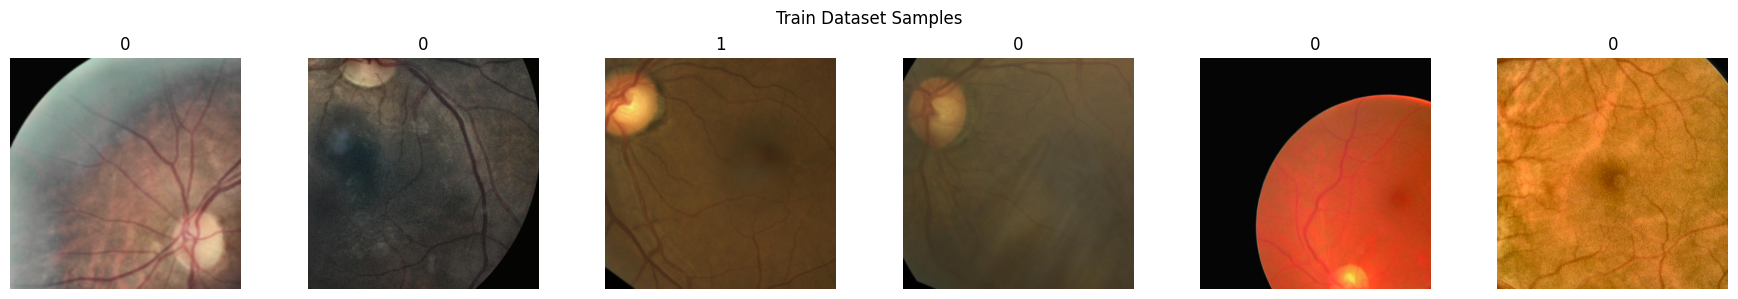

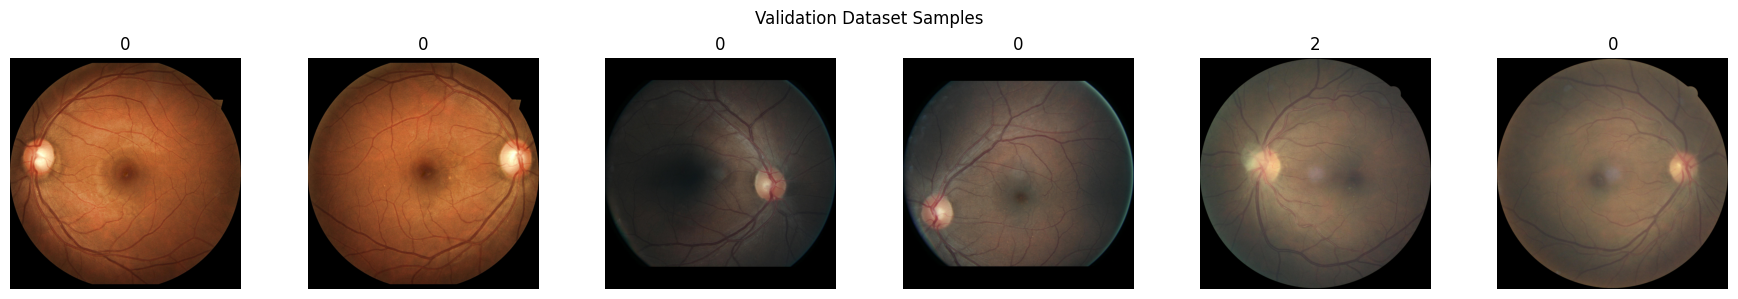

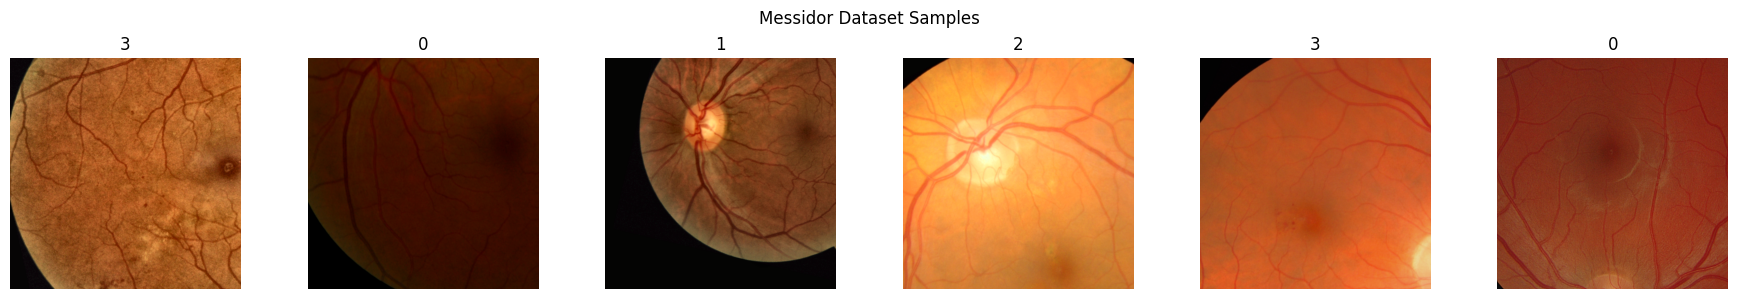

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

# ImageNet mean and std
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

# Function to unnormalize an image tensor
def unnormalize(image_tensor):
    # image_tensor: [C, H, W]
    return image_tensor * imagenet_std[:, None, None] + imagenet_mean[:, None, None]

# Function to show several images from a dataset
def show_images(dataset, num_images=6, title="Dataset Samples", unnormal=True):
    plt.figure(figsize=(num_images * 3, 3))
    for i in range(num_images):
        image, label = dataset[i]  # Assumes __getitem__ returns (image_tensor, label)
        if unnormal:
            image = unnormalize(image)  # Unnormalize
            image = torch.clamp(image, 0, 1)  # Ensure values are in [0, 1]
        image = F.to_pil_image(image)  # Convert to PIL Image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(str(label))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Usage
show_images(train_dataset, num_images=6, title="Train Dataset Samples")
show_images(val_dataset, num_images=6, title="Validation Dataset Samples")
show_images(messidor_dataset, num_images=6, title="Messidor Dataset Samples")

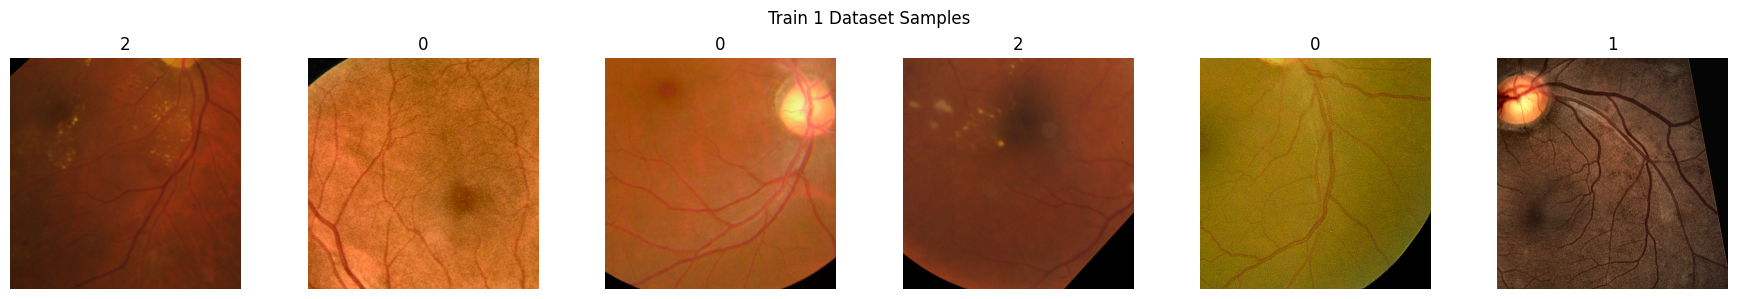

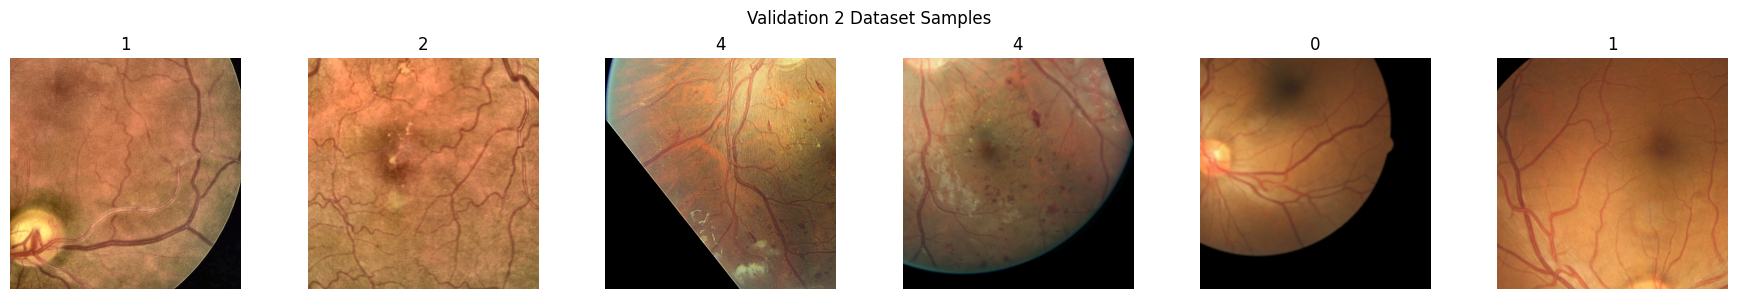

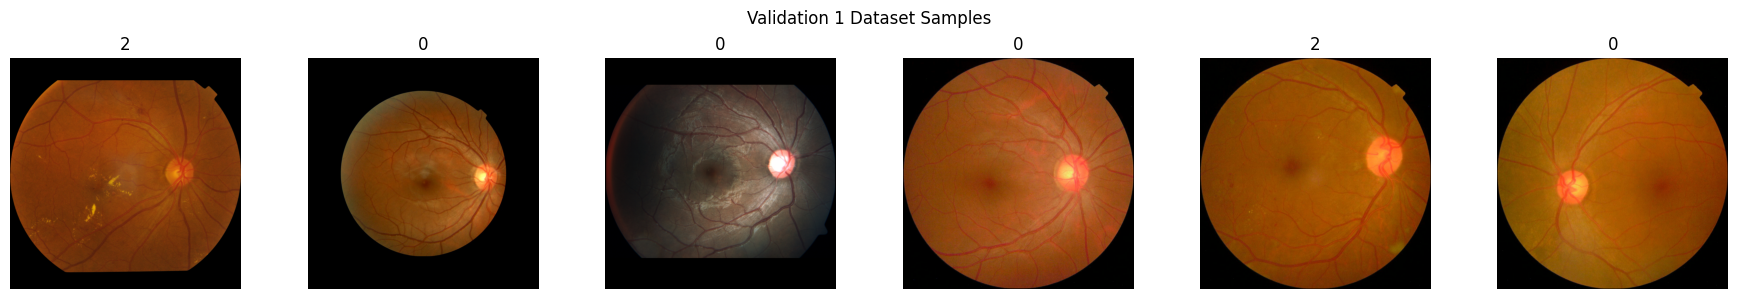

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

# ImageNet mean and std
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

# Function to unnormalize an image tensor
def unnormalize(image_tensor):
    # image_tensor: [C, H, W]
    return image_tensor * imagenet_std[:, None, None] + imagenet_mean[:, None, None]

# Function to show several images from a dataset
def show_images(dataset, num_images=6, title="Dataset Samples", unnormal=True):
    plt.figure(figsize=(num_images * 3, 3))
    for i in range(num_images):
        image, label = dataset[i]  # Assumes __getitem__ returns (image_tensor, label)
        if unnormal:
            image = unnormalize(image)  # Unnormalize
            image = torch.clamp(image, 0, 1)  # Ensure values are in [0, 1]
        image = F.to_pil_image(image)  # Convert to PIL Image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(str(label))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Usage
show_images(train1_dataset, num_images=6, title="Train 1 Dataset Samples")
show_images(trainval2_dataset, num_images=6, title="Validation 2 Dataset Samples")
show_images(val1_dataset, num_images=6, title="Validation 1 Dataset Samples")

In [5]:
import torch
import torch.nn.functional as F

import timm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau

/home/mauribuntu/miniconda3/envs/causal-dl-torch/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/mauribuntu/miniconda3/envs/causal-dl-torch/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/mauribuntu/miniconda3/envs/causal-dl-torch/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [6]:
from torch import nn

class AdjacentLabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing: float = 0.1, num_classes: int = 5, window_size: int = 1):
        """
        Exponential-decay label smoothing for ordinal targets.

        Args:
          smoothing: total probability mass to smooth away from the true class (0 <= s < 1).
          num_classes: total number of ordinal classes.
          window_size: how many steps to consider on each side of the true class.
                       (1 for adjacent only, 2 to include distance-2 neighbors, etc.)
        """
        super().__init__()
        assert 0 <= smoothing < 1, "smoothing must be in [0,1)."
        self.smoothing = smoothing
        self.num_classes = num_classes
        self.window_size = window_size

        # Precompute smoothing distributions for each possible true class 0..num_classes-1
        # according to your two requirements:
        #   1) exp decay by distance
        #   2) center weight = 1 - smoothing
        R = smoothing / (1.0 - smoothing)  # ratio of total neighbor mass to center mass

        weight_matrix = []
        for t in range(num_classes):
            # how many valid steps on each side
            left_n  = min(window_size,             t)
            right_n = min(window_size, num_classes - 1 - t)

            # Solve for decay d so that sum(d^1..d^left_n) + sum(d^1..d^right_n) = R
            # Newton's method on f(d) = sum_{k=1..L} d^k + sum_{k=1..R} d^k - R = 0
            if left_n + right_n == 0:
                d = 0.0
            else:
                # initial guess
                d = R / (left_n + right_n)
                for _ in range(50):
                    # f(d) and f'(d)
                    f = sum(d**k for k in range(1, left_n+1)) + sum(d**k for k in range(1, right_n+1)) - R
                    fp = sum(k * d**(k-1) for k in range(1, left_n+1)) + sum(k * d**(k-1) for k in range(1, right_n+1))
                    d = max(d - f/(fp + 1e-12), 1e-12)

            # Build raw (unnormalized) weights for this true class t
            raw = torch.zeros(num_classes, dtype=torch.float64)
            for c in range(num_classes):
                dist = abs(c - t)
                if dist == 0:
                    raw[c] = 1.0
                elif dist <= window_size:
                    raw[c] = d**dist
                # else remains 0

            # Normalize so sum(raw) = 1 and center weight = 1 - smoothing
            raw = raw / raw.sum()
            weight_matrix.append(raw.float())

        # Stack into [num_classes, num_classes] tensor
        weight_matrix = torch.stack(weight_matrix, dim=0)  # weight_matrix[t] is the distribution for true class t
        self.register_buffer('weight_matrix', weight_matrix)

    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        logits: (B, C)
        target: (B,) integer tensor in [0..C-1]
        """
        # Get the precomputed soft-target distributions
        # shape → (B, C)
        true_dist = self.weight_matrix[target]

        # Standard cross-entropy with log-softmax
        log_probs = F.log_softmax(logits, dim=-1)
        loss = -(true_dist * log_probs).sum(dim=-1).mean()
        return loss
    
    def debug_dist(self, true_class: int) -> torch.Tensor:
        """
        Returns the smoothed distribution for a given true class.

        Args:
            true_class: int, between 0 and num_classes - 1.

        Returns:
            A tensor of shape (num_classes,) showing the target distribution.
        """
        if not (0 <= true_class < self.num_classes):
            raise ValueError(f"true_class must be between 0 and {self.num_classes - 1}, got {true_class}.")
        
        dist = self.weight_matrix[true_class]
        return dist

## Model Classes

In [6]:
from torch import nn

class EfficientNetV2OrdinalClassifier(pl.LightningModule):
    def __init__(self, model_name="efficientnetv2_rw_m", lr=1e-4, num_classes=5):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        
        # Use timm to load pretrained backbone, remove classifier head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=0,  # remove original head
            
            drop_rate=0.3,
            drop_path_rate=0.3
        )

        in_features = self.net.num_features
        self.head = nn.Linear(in_features, self.num_classes - 1)  # 4 outputs for 5 ordinal classes

    def forward(self, x):
        features = self.net(x)
        logits = self.head(features)
        return logits
    
    def predict_class(self, logits):
        probas = logits.sigmoid()
        return (probas > 0.5).sum(dim=1)
    
    def ordinal_targets(self, labels):
        """
        Converts integer class labels (0 to num_classes - 1) into ordinal binary targets.
        For example, label 2 becomes [1, 1, 0, 0] for num_classes = 5
        """
        batch_size = labels.size(0)
        num_thresholds = self.num_classes - 1  # one less than number of classes
        labels_expanded = labels.unsqueeze(1)  # Expand labels to shape (batch_size, 1)
        # Create comparison thresholds: shape (1, num_thresholds) = [0, 1, 2, 3]
        thresholds = torch.arange(num_thresholds, device=labels.device).unsqueeze(0)
        # Compare each label to thresholds: True where label > threshold
        binary_targets = labels_expanded > thresholds  # shape (batch_size, num_thresholds)
        return binary_targets.float()

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        targets = self.ordinal_targets(labels)
        loss = F.binary_cross_entropy_with_logits(logits, targets)
        
        preds = (logits.sigmoid() > 0.5).sum(dim=1)
        acc = (preds == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        targets = self.ordinal_targets(labels)
        loss = F.binary_cross_entropy_with_logits(logits, targets)

        preds = (logits.sigmoid() > 0.5).sum(dim=1)
        acc = (preds == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc',  acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=5e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
class ConvNeXtClassifier(pl.LightningModule):
    def __init__(self, model_name="convnext_small.fb_in22k_ft_in1k_384", lr=1e-4, num_classes=5, smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            drop_rate=0.4,
            drop_path_rate=0.4,
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            num_classes=self.hparams.num_classes
        )

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
class EfficientNetV2Classifier(pl.LightningModule):
    def __init__(self, model_name="efficientnetv2_rw_m", lr=1e-4, num_classes=5, smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            drop_rate=0.4,        # 🔥 add stronger dropout (applied before final FC)
            drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            num_classes=self.hparams.num_classes
        )

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc',  acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
class ResNet50Classifier(pl.LightningModule):
    def __init__(self, model_name="resnet50.a1_in1k", lr=1e-4, num_classes=5,
                 smoothing=0.1, window_size=1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            drop_rate=0.3,        # 🔥 add stronger dropout (applied before final FC)
            # drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            window_size=self.hparams.window_size,
            num_classes=self.hparams.num_classes
        )

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        
        preds = logits.argmax(dim=-1)
        acc  = (preds == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)

        preds = logits.argmax(dim=-1)
        acc  = (preds == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc',  acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
class ConvNeXtRegressor(pl.LightningModule):
    def __init__(self, model_name="convnext_small.fb_in22k_ft_in1k_384", lr=1e-4, num_classes=5):
        super().__init__()
        self.save_hyperparameters()
        self.net = timm.create_model(
            model_name,
            pretrained=True,    # We will manually load weights later
            num_classes=1,        # One output neuron for regression
            
            drop_rate=0.2,
            drop_path_rate=0.2,
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # Output shape [batch_size]
    
    def predict_class(self, outputs):
        return outputs.round().clamp(0, self.hparams.num_classes - 1).long()

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.mse_loss(preds, labels.float())

        preds_rounded = preds.round().clamp(0, self.hparams.num_classes - 1)
        acc = (preds_rounded == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.mse_loss(preds, labels.float())

        preds_rounded = preds.round().clamp(0, self.hparams.num_classes - 1)
        acc = (preds_rounded == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc',  acc, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',          # still minimizing val_loss (MSE)
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=True
            ),
            'monitor': 'val_loss',   # watch val_loss (MSE) to reduce LR
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

    @classmethod
    def load_from_classifier_ckpt(cls, path, model_name="convnext_small.fb_in22k_ft_in1k_384",
                                  lr=1e-4, num_classes=5):
        """
        Create a ConvNeXtRegressor and load weights from a classification checkpoint.
        """
        model = cls(model_name=model_name, lr=lr)
        checkpoint = torch.load(path, map_location='cpu')

        state_dict = checkpoint['state_dict']

        # Remove classification head weights (they don't match)
        filtered_state_dict = {k: v for k, v in state_dict.items() if 'head' not in k}
        model.load_state_dict(filtered_state_dict, strict=False)
        return model

## Limbo

In [7]:
class ConvNeXtClassifier21(pl.LightningModule):
    def __init__(self, model_name="convnext_small.fb_in22k_ft_in1k_384", lr=1e-4, num_classes=5, smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            # drop_rate=0.4,
            # drop_path_rate=0.4,
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            num_classes=self.hparams.num_classes
        )

        # Freeze all layers except the classifier head
        self.freeze_conv_layers()

    def freeze_conv_layers(self):
        # Freeze all parameters
        for param in self.net.parameters():
            param.requires_grad = False
        
        # Unfreeze the classifier head (named 'head' in ConvNeXt)
        for param in self.net.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        # Only pass parameters that require gradients to the optimizer
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.lr,
            # weight_decay=1e-5
        )

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=2,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [8]:
class EfficientNetV2Classifier21(pl.LightningModule):
    def __init__(self, model_name="efficientnetv2_rw_m", lr=1e-4, num_classes=5, smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            # drop_rate=0.4,        # 🔥 add stronger dropout (applied before final FC)
            # drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            num_classes=self.hparams.num_classes
        )

        # Freeze all layers except the classifier head
        self.freeze_conv_layers()

    def freeze_conv_layers(self):
        # Freeze all parameters
        for param in self.net.parameters():
            param.requires_grad = False
        
        # Unfreeze the classifier head (named 'head' in ConvNeXt)
        for param in self.net.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc',  acc, prog_bar=True)

    def configure_optimizers(self):
        # Only pass parameters that require gradients to the optimizer
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.lr,
            # weight_decay=1e-5
        )

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=2,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [9]:
class ResNet50Classifier21(pl.LightningModule):
    def __init__(self, model_name="resnet50.a1_in1k", lr=1e-4, num_classes=5,
                 smoothing=0.1, window_size=1):
        super().__init__()
        self.save_hyperparameters()
        # create & swap in a new head
        self.net = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=self.hparams.num_classes,
            
            # drop_rate=0.3,        # 🔥 add stronger dropout (applied before final FC)
            # # drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )
        
        self.criterion = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing,
            window_size=self.hparams.window_size,
            num_classes=self.hparams.num_classes
        )

        # Freeze all layers except the classifier
        self.freeze_conv_layers()

    def freeze_conv_layers(self):
        # Freeze all parameters
        for param in self.net.parameters():
            param.requires_grad = False
        
        # Unfreeze the classifier (non-convolutional layer)
        for param in self.net.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.net(x)

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        
        preds = logits.argmax(dim=-1)
        acc  = (preds == labels).float().mean()

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)

        preds = logits.argmax(dim=-1)
        acc  = (preds == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc',  acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        # Only pass parameters that require gradients to the optimizer
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.lr,
            # weight_decay=1e-4
        )

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=2,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
model = ConvNeXtClassifier21(lr=1e-4, num_classes=5)
list(model.net.head.parameters())

## Avant-garde

In [7]:
class ConvNeXtClassifierMultiheaded(pl.LightningModule):
    def __init__(self, model_name="convnext_small.fb_in22k_ft_in1k_384",
                 lr=1e-4, num_classes_5=5, num_classes_4=4, smoothing_5=0.1, smoothing_4=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Create backbone with num_classes=0 to get features only
        self.backbone = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=0,  # Feature extractor mode
            
            drop_rate=0.4,
            drop_path_rate=0.4,
        )

        # Get feature dimension from backbone
        feature_dim = self.backbone.num_features

        # Define separate heads for each task
        self.head_5 = nn.Linear(feature_dim, self.hparams.num_classes_5)
        self.head_4 = nn.Linear(feature_dim, self.hparams.num_classes_4)
        
        # Define separate loss functions for each task
        self.criterion_5 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_5,
            num_classes=self.hparams.num_classes_5
        )
        self.criterion_4 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_4,
            num_classes=self.hparams.num_classes_4
        )

    def forward(self, x, task='5_class'):
        features = self.backbone(x)
        if task == '5_class':
            return self.head_5(features)
        elif task == '4_class':
            return self.head_4(features)
        else:
            raise ValueError("Invalid task: choose '5_class' or '4_class'")

    def predict_class(self, logits):
        return logits.argmax(dim=-1)
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch[0]
        logits = self(imgs, task='5_class')
        loss1 = self.criterion_5(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()

        bs = labels.size(0) # Some Lightning bs
        self.log('train_loss', loss1, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        self.log('train_acc',  acc, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        
        imgs, labels = batch[1]
        logits = self(imgs, task='4_class')
        loss2 = self.criterion_4(logits, labels)
        
        return loss1 + loss2

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs, task='5_class')
        loss = self.criterion_5(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        bs = labels.size(0) # Some Lightning bs
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=3,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
import math

class ConvNeXtClassifierMultiheaded(pl.LightningModule):
    def __init__(self, model_name="convnext_small.fb_in22k_ft_in1k_384",
                 lr=1e-4, num_classes_5=5, num_classes_4=4, smoothing_5=0.1, smoothing_4=0.1,
                 temperature=1.0):
        super().__init__()
        self.save_hyperparameters()

        # Create backbone with num_classes=0 to get features only
        self.backbone = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=0,  # Feature extractor mode
            
            drop_rate=0.4,
            drop_path_rate=0.4,
        )

        # Get feature dimension from backbone
        feature_dim = self.backbone.num_features

        # Define separate heads for each task
        self.head_5 = nn.Linear(feature_dim, self.hparams.num_classes_5)
        self.head_4 = nn.Linear(feature_dim, self.hparams.num_classes_4)
        
        # Define separate loss functions for each task
        self.criterion_5 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_5,
            num_classes=self.hparams.num_classes_5
        )
        self.criterion_4 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_4,
            num_classes=self.hparams.num_classes_4
        )

        self.register_buffer('last_loss5', torch.tensor(math.log(self.hparams.num_classes_5)))
        self.register_buffer('last_loss4', torch.tensor(math.log(self.hparams.num_classes_4)))

    def forward(self, x, task='5_class'):
        features = self.backbone(x)
        if task == '5_class':
            return self.head_5(features)
        elif task == '4_class':
            return self.head_4(features)
        else:
            raise ValueError("Invalid task: choose '5_class' or '4_class'")

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def on_train_epoch_start(self):            
        lambda5 = self.last_loss5 / math.log(self.hparams.num_classes_5) / self.hparams.temperature
        lambda4 = self.last_loss4 / math.log(self.hparams.num_classes_4) / self.hparams.temperature

        exp_l5 = torch.exp(lambda5)
        exp_l4 = torch.exp(lambda4)
        sum_exp_l = exp_l5 + exp_l4
        
        self.current_w5 = exp_l5 / sum_exp_l 
        self.current_w4 = exp_l4 / sum_exp_l
    
    def training_step(self, batch, batch_idx):
        (imgs5, labels5), (imgs4, labels4) = batch

        logits5 = self(imgs5, task='5_class')
        loss5 = self.criterion_5(logits5, labels5)
        acc5  = (logits5.argmax(dim=-1) == labels5).float().mean()

        bs5 = labels5.size(0) # Some Lightning bs
        self.log('train_loss', loss5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        self.log('train_acc',  acc5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        
        logits4 = self(imgs4, task='4_class')
        loss4 = self.criterion_4(logits4, labels4)
        
        bs4 = labels4.size(0) # Some Lightning bs
        self.log('loss4', loss4, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs4)
        
        return self.current_w5 * loss5 / math.log(self.hparams.num_classes_5) + \
               self.current_w4 * loss4 / math.log(self.hparams.num_classes_4)

    def on_train_epoch_end(self):
        logged_metrics = self.trainer.callback_metrics
        self.last_loss5 = logged_metrics['train_loss']
        self.last_loss4 = logged_metrics['loss4']

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs, task='5_class')
        loss = self.criterion_5(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        bs = labels.size(0) # Some Lightning bs
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
import math

class EfficientNetV2ClassifierMultiheaded(pl.LightningModule):
    def __init__(self, model_name="efficientnetv2_rw_m",
                 lr=1e-4, num_classes_5=5, num_classes_4=4, smoothing_5=0.1, smoothing_4=0.1,
                 temperature=1.0):
        super().__init__()
        self.save_hyperparameters()

        # Create backbone with num_classes=0 to get features only
        self.backbone = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=0,  # Feature extractor mode
            
            drop_rate=0.4,        # 🔥 add stronger dropout (applied before final FC)
            drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )

        # Get feature dimension from backbone
        feature_dim = self.backbone.num_features

        # Define separate heads for each task
        self.head_5 = nn.Linear(feature_dim, self.hparams.num_classes_5)
        self.head_4 = nn.Linear(feature_dim, self.hparams.num_classes_4)
        
        # Define separate loss functions for each task
        self.criterion_5 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_5,
            num_classes=self.hparams.num_classes_5
        )
        self.criterion_4 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_4,
            num_classes=self.hparams.num_classes_4
        )

        self.register_buffer('last_loss5', torch.tensor(math.log(self.hparams.num_classes_5)))
        self.register_buffer('last_loss4', torch.tensor(math.log(self.hparams.num_classes_4)))

    def forward(self, x, task='5_class'):
        features = self.backbone(x)
        if task == '5_class':
            return self.head_5(features)
        elif task == '4_class':
            return self.head_4(features)
        else:
            raise ValueError("Invalid task: choose '5_class' or '4_class'")

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def on_train_epoch_start(self):            
        lambda5 = self.last_loss5 / math.log(self.hparams.num_classes_5) / self.hparams.temperature
        lambda4 = self.last_loss4 / math.log(self.hparams.num_classes_4) / self.hparams.temperature

        exp_l5 = torch.exp(lambda5)
        exp_l4 = torch.exp(lambda4)
        sum_exp_l = exp_l5 + exp_l4
        
        self.current_w5 = exp_l5 / sum_exp_l 
        self.current_w4 = exp_l4 / sum_exp_l
    
    def training_step(self, batch, batch_idx):
        (imgs5, labels5), (imgs4, labels4) = batch

        logits5 = self(imgs5, task='5_class')
        loss5 = self.criterion_5(logits5, labels5)
        acc5  = (logits5.argmax(dim=-1) == labels5).float().mean()

        bs5 = labels5.size(0) # Some Lightning bs
        self.log('train_loss', loss5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        self.log('train_acc',  acc5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        
        logits4 = self(imgs4, task='4_class')
        loss4 = self.criterion_4(logits4, labels4)
        
        bs4 = labels4.size(0) # Some Lightning bs
        self.log('loss4', loss4, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs4)
        
        return self.current_w5 * loss5 / math.log(self.hparams.num_classes_5) + \
               self.current_w4 * loss4 / math.log(self.hparams.num_classes_4)

    def on_train_epoch_end(self):
        logged_metrics = self.trainer.callback_metrics
        self.last_loss5 = logged_metrics['train_loss']
        self.last_loss4 = logged_metrics['loss4']

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs, task='5_class')
        loss = self.criterion_5(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        bs = labels.size(0) # Some Lightning bs
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
import math

class ResNet50ClassifierMultiheaded(pl.LightningModule):
    def __init__(self, model_name="resnet50.a1_in1k",
                 lr=1e-4, num_classes_5=5, num_classes_4=4, smoothing_5=0.1, smoothing_4=0.1,
                 temperature=1.0):
        super().__init__()
        self.save_hyperparameters()

        # Create backbone with num_classes=0 to get features only
        self.backbone = timm.create_model(
            self.hparams.model_name,
            pretrained=True,
            num_classes=0,  # Feature extractor mode
            
            drop_rate=0.3,        # 🔥 add stronger dropout (applied before final FC)
            # drop_path_rate=0.3,   # 🔥 stochastic depth (helps regularize deep nets)
        )

        # Get feature dimension from backbone
        feature_dim = self.backbone.num_features

        # Define separate heads for each task
        self.head_5 = nn.Linear(feature_dim, self.hparams.num_classes_5)
        self.head_4 = nn.Linear(feature_dim, self.hparams.num_classes_4)
        
        # Define separate loss functions for each task
        self.criterion_5 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_5,
            num_classes=self.hparams.num_classes_5
        )
        self.criterion_4 = AdjacentLabelSmoothingLoss(
            smoothing=self.hparams.smoothing_4,
            num_classes=self.hparams.num_classes_4
        )

        self.register_buffer('last_loss5', torch.tensor(math.log(self.hparams.num_classes_5)))
        self.register_buffer('last_loss4', torch.tensor(math.log(self.hparams.num_classes_4)))

    def forward(self, x, task='5_class'):
        features = self.backbone(x)
        if task == '5_class':
            return self.head_5(features)
        elif task == '4_class':
            return self.head_4(features)
        else:
            raise ValueError("Invalid task: choose '5_class' or '4_class'")

    def predict_class(self, logits):
        return logits.argmax(dim=-1)

    def on_train_epoch_start(self):            
        lambda5 = self.last_loss5 / math.log(self.hparams.num_classes_5) / self.hparams.temperature
        lambda4 = self.last_loss4 / math.log(self.hparams.num_classes_4) / self.hparams.temperature

        exp_l5 = torch.exp(lambda5)
        exp_l4 = torch.exp(lambda4)
        sum_exp_l = exp_l5 + exp_l4
        
        self.current_w5 = exp_l5 / sum_exp_l 
        self.current_w4 = exp_l4 / sum_exp_l
    
    def training_step(self, batch, batch_idx):
        (imgs5, labels5), (imgs4, labels4) = batch

        logits5 = self(imgs5, task='5_class')
        loss5 = self.criterion_5(logits5, labels5)
        acc5  = (logits5.argmax(dim=-1) == labels5).float().mean()

        bs5 = labels5.size(0) # Some Lightning bs
        self.log('train_loss', loss5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        self.log('train_acc',  acc5, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs5)
        
        logits4 = self(imgs4, task='4_class')
        loss4 = self.criterion_4(logits4, labels4)
        
        bs4 = labels4.size(0) # Some Lightning bs
        self.log('loss4', loss4, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs4)
        
        return self.current_w5 * loss5 / math.log(self.hparams.num_classes_5) + \
               self.current_w4 * loss4 / math.log(self.hparams.num_classes_4)

    def on_train_epoch_end(self):
        logged_metrics = self.trainer.callback_metrics
        self.last_loss5 = logged_metrics['train_loss']
        self.last_loss4 = logged_metrics['loss4']

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs, task='5_class')
        loss = self.criterion_5(logits, labels)
        acc  = (logits.argmax(dim=-1) == labels).float().mean()
        
        bs = labels.size(0) # Some Lightning bs
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)
        self.log('val_acc',  acc, prog_bar=True, on_step=False, on_epoch=True,
                 batch_size=bs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)

        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',              # we're watching val_loss (lower is better)
                factor=0.5,              # reduce LR by this factor
                patience=5,              # after N epochs of no improvement
                min_lr=1e-6,             # don’t go below this
                verbose=True
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

## Train!

In [ ]:
# from timm.data import resolve_data_config
# from timm.layers import apply_test_time_pool
import mlflow.pytorch

mlflow.pytorch.autolog()

# pl.seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='effnet-v2rw-m-sv768-dropout-l2reg-augs-adjsmooth-part2-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    save_top_k=1,
    mode='min',
)
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[earlystop_cb, checkpoint_cb],
    accelerator='auto',  # GPU if available
    precision='16-mixed',
    devices=1,
)

model = EfficientNetV2Classifier(lr=1e-4, num_classes=5)
checkpoint = torch.load('checkpoints/effnet-v2rw-m-dropout-l2reg-augs-adjsmooth-full-epoch=14-val_loss=0.7004-val_acc=0.8305.ckpt')
model.load_state_dict(checkpoint['state_dict'], strict=False)

# # Weird TIMM thing to deal with varied image sizes
# data_config = resolve_data_config({}, model=model)
# data_config['input_size'] = [3, IMAGE_SIZE_VAL, IMAGE_SIZE_VAL]
# model, using_test_pool = apply_test_time_pool(model, data_config)
# if using_test_pool:
#     print("✅ Test-Time Pool head is in place.")

trainer.fit(model, train_dataloader, val_dataloader)

print("✅ Best checkpoint:", checkpoint_cb.best_model_path)

.

In [8]:
import mlflow.pytorch

mlflow.pytorch.autolog()

# pl.seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='convnext-small-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refined-finetune1-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    save_top_k=1,
    mode='min',
)
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
)

trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[earlystop_cb, checkpoint_cb],
    accelerator='auto',  # GPU if available
    precision='16-mixed',
    devices=1,
)

model = ConvNeXtClassifier(lr=1e-4, num_classes=5)
ckpt = torch.load('checkpoints/convnext-small-2head-extra_data-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refined-epoch=05-val_loss=0.6122-val_acc=0.8703.ckpt')
ckpt_state_dict = ckpt['state_dict']

# Create a new state dict with mapped keys
model_state_dict = model.state_dict()

# Map backbone weights (replace 'net.' with 'backbone.')
for key in ckpt_state_dict.keys():
    if key.startswith('backbone.'):
        model_key = key.replace('backbone.', 'net.')
        model_state_dict[model_key] = ckpt_state_dict[key]

# Map the original classifier weights
model_state_dict['net.head.fc.weight'] = ckpt_state_dict['head_5.weight']
model_state_dict['net.head.fc.bias'] = ckpt_state_dict['head_5.bias']

# Load the new state dict into the model
model.load_state_dict(model_state_dict)

# Freeze all layers
for param in model.net.parameters():
    param.requires_grad = False
# Unfreeze the classifier head (named 'head' in ConvNeXt)
for param in model.net.head.parameters():
    param.requires_grad = True

trainer.fit(model, train_dataloader, val_dataloader)
            # ckpt_path='checkpoints/convnext-small-sv728dyn-rand_shrink-dropout-l2reg-augs-adjsmooth-train2-refine1-epoch=08-val_loss=0.6373-val_acc=0.8520.ckpt')

print("✅ Best checkpoint:", checkpoint_cb.best_model_path)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/tmp/ipykernel_12952/3200271583.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits th

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/05/13 19:21:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/13 19:21:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pytorch autologging: [Errno 5] Input/output error: '/mnt/g/Kaggle-Diabetic-Retinopathy/checkpoints/convnext-small-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refined-finetune1-epoch=02-val_loss=0.6661-val_acc=0.8345.ckpt' -> '/mnt/g/Kaggle-Diabetic-Retinopathy/mlruns/0/b3299f6229d14c10bcfaf2178c327365/artifacts/restored_model_checkpoint/convnext-small-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refined-finetune1-epoch=02-val_loss=0.6661-val_acc=0.8345.ckpt'


✅ Best checkpoint: /mnt/g/Kaggle-Diabetic-Retinopathy/checkpoints/convnext-small-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refined-finetune1-epoch=02-val_loss=0.6661-val_acc=0.8345.ckpt


.

In [8]:
from lightning.pytorch.utilities import CombinedLoader

import mlflow.pytorch
mlflow.pytorch.autolog()

# pl.seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='effnet-v2rw-m-2head-extra_data-st400-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refine1-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    save_top_k=1,
    mode='min',
)
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
)

trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[earlystop_cb, checkpoint_cb],
    accelerator='auto',  # GPU if available
    accumulate_grad_batches=4,
    precision='16-mixed',
    devices=1
)

model = EfficientNetV2ClassifierMultiheaded(lr=1e-5, num_classes_5=5, num_classes_4=4)
ckpt = torch.load('checkpoints/effnet-v2rw-m-sv768-dropout-l2reg-augs-adjsmooth-part2-epoch=46-val_loss=0.6480-val_acc=0.8508.ckpt')
ckpt_state_dict = ckpt['state_dict']

# Create a new state dict with mapped keys
model_state_dict = model.state_dict()

# Map backbone weights (replace 'net.' with 'backbone.')
for key in model_state_dict.keys():
    if key.startswith('backbone.'):
        ckpt_key = key.replace('backbone.', 'net.')
        model_state_dict[key] = ckpt_state_dict[ckpt_key]

# # Map the original classifier weights to head_5
# model_state_dict['head_5.weight'] = ckpt_state_dict['net.head.fc.weight']
# model_state_dict['head_5.bias'] = ckpt_state_dict['net.head.fc.bias']
# # # model_state_dict['head_4.weight'] = ckpt_state_dict['net.head.fc.weight']
# # # model_state_dict['head_4.bias'] = ckpt_state_dict['net.head.fc.bias']

# EffNet v2 counterpart:
model_state_dict['head_5.weight'] = ckpt_state_dict['net.classifier.weight']
model_state_dict['head_5.bias'] = ckpt_state_dict['net.classifier.bias']

# # ResNet 50 counterpart:
# model_state_dict['head_5.weight'] = ckpt_state_dict['net.fc.weight']
# model_state_dict['head_5.bias'] = ckpt_state_dict['net.fc.bias']

# Load the new state dict into the model
model.load_state_dict(model_state_dict)
# model.load_state_dict(ckpt_state_dict)

trainer.fit(model,
            train_dataloaders=[train_dataloader, messidor_dataloader],
            val_dataloaders=val_dataloader)
            # ckpt_path='checkpoints/convnext-small-2head-extra_data-st448-sv768-dropout-l2reg-augs2-adjsmooth-train2-refine1-epoch=07-val_loss=0.6267-val_acc=0.8531.ckpt')

# trainer.fit(model,
#             train_dataloaders=[train1_dataloader, trainval2_dataloader],
#             val_dataloaders=val1_dataloader)
#             # ckpt_path='checkpoints/convnext-small-2head-st448-sv768-dropout-l2reg-augs2-adjsmooth-train_sym12-val2-epoch=05-val_loss=0.7156-val_acc=0.8045.ckpt')

print("✅ Best checkpoint:", checkpoint_cb.best_model_path)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/tmp/ipykernel_9474/517676097.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025/05/13 10:13:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Best checkpoint: /mnt/g/Kaggle-Diabetic-Retinopathy/checkpoints/effnet-v2rw-m-2head-extra_data-st448-sv768dyn-rand_shrink-dropout-l2reg-augs2-adjsmooth-train2-refine1-epoch=05-val_loss=0.6989-val_acc=0.8329.ckpt
